In [34]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# ============================================================================
# COMPREHENSIVE DEFAULT PROBABILITY VISUALIZATION
# ============================================================================

def plot_default_probability_analysis(y_true, y_pred_proba, scores=None, model_name="Credit Scorecard"):
    """
    Complete visualization suite for default probability predictions

    Parameters:
    -----------
    y_true : array-like
        True binary labels (0=Good, 1=Default)
    y_pred_proba : array-like
        Predicted probabilities of default
    scores : array-like, optional
        Credit scores (if available)
    model_name : str
        Name of the model for titles
    """

    # Create main figure with subplots
    fig = plt.figure(figsize=(20, 15))

    # ========================================================================
    # 1. PROBABILITY DISTRIBUTION BY CLASS
    # ========================================================================
    ax1 = plt.subplot(3, 4, 1)

    # Separate predictions by actual outcome
    good_probs = y_pred_proba[y_true == 0]
    bad_probs = y_pred_proba[y_true == 1]

    ax1.hist(good_probs, bins=50, alpha=0.6, label='Good Loans (No Default)',
             color='green', edgecolor='black', density=True)
    ax1.hist(bad_probs, bins=50, alpha=0.6, label='Bad Loans (Default)',
             color='red', edgecolor='black', density=True)

    ax1.axvline(good_probs.mean(), color='green', linestyle='--', linewidth=2,
                label=f'Good Mean: {good_probs.mean():.3f}')
    ax1.axvline(bad_probs.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Bad Mean: {bad_probs.mean():.3f}')

    ax1.set_xlabel('Predicted Probability of Default')
    ax1.set_ylabel('Density')
    ax1.set_title('Distribution of Default Probabilities\nby Actual Outcome', fontweight='bold')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # ========================================================================
    # 2. ROC CURVE WITH DETAILED METRICS
    # ========================================================================
    ax2 = plt.subplot(3, 4, 2)

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_score - 1

    ax2.plot(fpr, tpr, linewidth=3, label=f'Model (AUC={auc_score:.4f}, Gini={gini:.4f})',
             color='darkblue')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Model (AUC=0.5)')
    ax2.fill_between(fpr, tpr, alpha=0.2)

    # Find optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    ax2.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
             label=f'Optimal Point (Threshold={optimal_threshold:.3f})')

    ax2.set_xlabel('False Positive Rate (1 - Specificity)')
    ax2.set_ylabel('True Positive Rate (Sensitivity)')
    ax2.set_title('ROC Curve - Model Discrimination Power', fontweight='bold')
    ax2.legend(loc='lower right', fontsize=8)
    ax2.grid(True, alpha=0.3)

    # ========================================================================
    # 3. PRECISION-RECALL CURVE
    # ========================================================================
    ax3 = plt.subplot(3, 4, 3)

    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)

    ax3.plot(recall, precision, linewidth=3, color='purple')
    ax3.axhline(y=y_true.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Baseline (Default Rate={y_true.mean():.3f})')
    ax3.fill_between(recall, precision, alpha=0.2)

    ax3.set_xlabel('Recall (True Positive Rate)')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve', fontweight='bold')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True, alpha=0.3)

    # ========================================================================
    # 4. CALIBRATION CURVE (RELIABILITY DIAGRAM)
    # ========================================================================
    ax4 = plt.subplot(3, 4, 4)

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=10, strategy='quantile'
    )

    ax4.plot(mean_predicted_value, fraction_of_positives, 's-', linewidth=2,
             markersize=8, label='Model Calibration', color='darkgreen')
    ax4.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

    ax4.set_xlabel('Mean Predicted Probability')
    ax4.set_ylabel('Fraction of Positives (Actual)')
    ax4.set_title('Calibration Curve\n(Reliability Diagram)', fontweight='bold')
    ax4.legend(loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)

    # ========================================================================
    # 5. DEFAULT RATE BY PROBABILITY DECILES
    # ========================================================================
    ax5 = plt.subplot(3, 4, 5)

    # Create deciles
    df_analysis = pd.DataFrame({
        'prob': y_pred_proba,
        'actual': y_true
    })
    df_analysis['decile'] = pd.qcut(df_analysis['prob'], q=10, labels=False, duplicates='drop')

    decile_stats = df_analysis.groupby('decile').agg({
        'actual': ['mean', 'count'],
        'prob': 'mean'
    }).reset_index()
    decile_stats.columns = ['decile', 'actual_default_rate', 'count', 'predicted_prob']

    x = np.arange(len(decile_stats))
    width = 0.35

    bars1 = ax5.bar(x - width/2, decile_stats['predicted_prob'], width,
                    label='Predicted Probability', color='steelblue', alpha=0.8)
    bars2 = ax5.bar(x + width/2, decile_stats['actual_default_rate'], width,
                    label='Actual Default Rate', color='coral', alpha=0.8)

    ax5.set_xlabel('Probability Decile (0=Lowest Risk, 9=Highest Risk)')
    ax5.set_ylabel('Default Rate')
    ax5.set_title('Predicted vs Actual Default Rate by Decile', fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels([f'D{i}' for i in range(len(decile_stats))])
    ax5.legend(fontsize=8)
    ax5.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2%}', ha='center', va='bottom', fontsize=7)

    # ========================================================================
    # 6. CUMULATIVE GAINS CHART
    # ========================================================================
    ax6 = plt.subplot(3, 4, 6)

    # Sort by predicted probability (descending)
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    y_sorted = y_true[sorted_indices]

    cumulative_defaults = np.cumsum(y_sorted)
    total_defaults = y_sorted.sum()
    population_pct = np.arange(1, len(y_sorted) + 1) / len(y_sorted) * 100
    gains = cumulative_defaults / total_defaults * 100

    ax6.plot(population_pct, gains, linewidth=2, label='Model', color='darkblue')
    ax6.plot([0, 100], [0, 100], 'k--', linewidth=2, label='Random Model')
    ax6.fill_between(population_pct, gains, population_pct, alpha=0.2)

    ax6.set_xlabel('% of Population (Ordered by Risk)')
    ax6.set_ylabel('% of Defaults Captured')
    ax6.set_title('Cumulative Gains Chart', fontweight='bold')
    ax6.legend(loc='lower right', fontsize=8)
    ax6.grid(True, alpha=0.3)

    # Add annotation for 20% population
    idx_20 = int(len(population_pct) * 0.2)
    ax6.plot([population_pct[idx_20]], [gains[idx_20]], 'ro', markersize=8)
    ax6.annotate(f'{gains[idx_20]:.1f}% defaults\nin top 20%',
                xy=(population_pct[idx_20], gains[idx_20]),
                xytext=(30, gains[idx_20]-20),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=8, color='red')

    # ========================================================================
    # 7. LIFT CHART
    # ========================================================================
    ax7 = plt.subplot(3, 4, 7)

    # Calculate lift for each decile
    lift = (decile_stats['actual_default_rate'] / y_true.mean())

    ax7.bar(range(len(lift)), lift, color='teal', alpha=0.7, edgecolor='black')
    ax7.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (Lift=1)')

    ax7.set_xlabel('Probability Decile (0=Lowest Risk, 9=Highest Risk)')
    ax7.set_ylabel('Lift')
    ax7.set_title('Lift Chart by Decile', fontweight='bold')
    ax7.set_xticks(range(len(lift)))
    ax7.set_xticklabels([f'D{i}' for i in range(len(lift))])
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for i, v in enumerate(lift):
        ax7.text(i, v + 0.1, f'{v:.2f}x', ha='center', va='bottom', fontsize=8, fontweight='bold')

    # ========================================================================
    # 8. KS STATISTIC VISUALIZATION
    # ========================================================================
    ax8 = plt.subplot(3, 4, 8)

    # Calculate KS statistic
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    y_sorted = y_true[sorted_indices]

    n_goods = (y_sorted == 0).sum()
    n_bads = (y_sorted == 1).sum()

    cum_goods = np.cumsum(y_sorted == 0) / n_goods * 100
    cum_bads = np.cumsum(y_sorted == 1) / n_bads * 100
    ks_values = cum_bads - cum_goods
    ks_stat = ks_values.max()
    ks_idx = ks_values.argmax()

    population_pct = np.arange(1, len(y_sorted) + 1) / len(y_sorted) * 100

    ax8.plot(population_pct, cum_goods, linewidth=2, label='Cumulative % Good', color='green')
    ax8.plot(population_pct, cum_bads, linewidth=2, label='Cumulative % Bad', color='red')

    # Mark KS point
    ax8.plot([population_pct[ks_idx], population_pct[ks_idx]],
             [cum_goods[ks_idx], cum_bads[ks_idx]],
             'k--', linewidth=2)
    ax8.plot(population_pct[ks_idx], cum_goods[ks_idx], 'go', markersize=10)
    ax8.plot(population_pct[ks_idx], cum_bads[ks_idx], 'ro', markersize=10)

    ax8.text(population_pct[ks_idx] + 5, (cum_goods[ks_idx] + cum_bads[ks_idx]) / 2,
             f'KS = {ks_stat:.2f}%', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    ax8.set_xlabel('% of Population (Ordered by Risk)')
    ax8.set_ylabel('Cumulative %')
    ax8.set_title('Kolmogorov-Smirnov (KS) Statistic', fontweight='bold')
    ax8.legend(loc='lower right', fontsize=8)
    ax8.grid(True, alpha=0.3)

    # ========================================================================
    # 9. CONFUSION MATRIX AT OPTIMAL THRESHOLD
    # ========================================================================
    ax9 = plt.subplot(3, 4, 9)

    y_pred_binary = (y_pred_proba >= optimal_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax9,
                xticklabels=['Predicted Good', 'Predicted Bad'],
                yticklabels=['Actual Good', 'Actual Bad'])

    ax9.set_title(f'Confusion Matrix\n(Threshold={optimal_threshold:.3f})', fontweight='bold')

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    metrics_text = f'Accuracy: {accuracy:.2%}\nPrecision: {precision:.2%}\nRecall: {recall:.2%}\nSpecificity: {specificity:.2%}'
    ax9.text(1.5, 0.5, metrics_text, fontsize=9,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # ========================================================================
    # 10. THRESHOLD ANALYSIS
    # ========================================================================
    ax10 = plt.subplot(3, 4, 10)

    thresholds_range = np.linspace(0, 1, 100)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for thresh in thresholds_range:
        y_pred_temp = (y_pred_proba >= thresh).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_temp).ravel()

        acc = (tp + tn) / (tp + tn + fp + fn)
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        accuracy_scores.append(acc)
        precision_scores.append(prec)
        recall_scores.append(rec)
        f1_scores.append(f1)

    ax10.plot(thresholds_range, accuracy_scores, label='Accuracy', linewidth=2)
    ax10.plot(thresholds_range, precision_scores, label='Precision', linewidth=2)
    ax10.plot(thresholds_range, recall_scores, label='Recall', linewidth=2)
    ax10.plot(thresholds_range, f1_scores, label='F1 Score', linewidth=2)

    ax10.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2,
                 label=f'Optimal={optimal_threshold:.3f}')

    ax10.set_xlabel('Classification Threshold')
    ax10.set_ylabel('Score')
    ax10.set_title('Performance Metrics vs Threshold', fontweight='bold')
    ax10.legend(loc='best', fontsize=8)
    ax10.grid(True, alpha=0.3)

    # ========================================================================
    # 11. RISK SEGMENTS ANALYSIS
    # ========================================================================
    ax11 = plt.subplot(3, 4, 11)

    # Define risk segments
    risk_segments = pd.cut(y_pred_proba,
                          bins=[0, 0.05, 0.15, 0.30, 1.0],
                          labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk'])

    segment_analysis = pd.DataFrame({
        'segment': risk_segments,
        'actual': y_true
    }).groupby('segment').agg({
        'actual': ['count', 'sum', 'mean']
    }).reset_index()

    segment_analysis.columns = ['segment', 'count', 'defaults', 'default_rate']
    segment_analysis['pct_population'] = segment_analysis['count'] / segment_analysis['count'].sum() * 100

    # Create dual axis plot
    x = np.arange(len(segment_analysis))

    color = 'steelblue'
    ax11.bar(x, segment_analysis['count'], color=color, alpha=0.6, label='# Applicants')
    ax11.set_xlabel('Risk Segment')
    ax11.set_ylabel('Number of Applicants', color=color)
    ax11.tick_params(axis='y', labelcolor=color)
    ax11.set_xticks(x)
    ax11.set_xticklabels(segment_analysis['segment'], rotation=15, ha='right')

    ax11_twin = ax11.twinx()
    color = 'red'
    ax11_twin.plot(x, segment_analysis['default_rate'] * 100, 'ro-', linewidth=3,
                   markersize=10, label='Default Rate')
    ax11_twin.set_ylabel('Default Rate (%)', color=color)
    ax11_twin.tick_params(axis='y', labelcolor=color)

    ax11.set_title('Risk Segmentation Analysis', fontweight='bold')
    ax11.grid(True, alpha=0.3, axis='y')

    # ========================================================================
    # 12. SCORE DISTRIBUTION (IF AVAILABLE)
    # ========================================================================
    ax12 = plt.subplot(3, 4, 12)

    if scores is not None:
        good_scores = scores[y_true == 0]
        bad_scores = scores[y_true == 1]

        ax12.hist(good_scores, bins=50, alpha=0.6, label='Good Loans',
                 color='green', edgecolor='black', density=True)
        ax12.hist(bad_scores, bins=50, alpha=0.6, label='Bad Loans (Default)',
                 color='red', edgecolor='black', density=True)

        ax12.axvline(good_scores.mean(), color='green', linestyle='--', linewidth=2,
                    label=f'Good Mean: {good_scores.mean():.0f}')
        ax12.axvline(bad_scores.mean(), color='red', linestyle='--', linewidth=2,
                    label=f'Bad Mean: {bad_scores.mean():.0f}')

        ax12.set_xlabel('Credit Score')
        ax12.set_ylabel('Density')
        ax12.set_title('Credit Score Distribution\nby Loan Outcome', fontweight='bold')
        ax12.legend(loc='upper right', fontsize=8)
    else:
        # Create summary statistics table
        ax12.axis('off')

        summary_stats = pd.DataFrame({
            'Metric': ['Total Samples', 'Actual Defaults', 'Default Rate',
                      'Mean Pred Prob (Good)', 'Mean Pred Prob (Bad)',
                      'AUC-ROC', 'Gini Coefficient', 'KS Statistic',
                      'Optimal Threshold'],
            'Value': [
                f'{len(y_true):,}',
                f'{y_true.sum():,}',
                f'{y_true.mean():.2%}',
                f'{good_probs.mean():.4f}',
                f'{bad_probs.mean():.4f}',
                f'{auc_score:.4f}',
                f'{gini:.4f}',
                f'{ks_stat:.2f}%',
                f'{optimal_threshold:.4f}'
            ]
        })

        table = ax12.table(cellText=summary_stats.values,
                          colLabels=summary_stats.columns,
                          cellLoc='left',
                          loc='center',
                          colWidths=[0.6, 0.4])

        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)

        # Style header
        for i in range(len(summary_stats.columns)):
            table[(0, i)].set_facecolor('#4472C4')
            table[(0, i)].set_text_props(weight='bold', color='white')

        # Alternate row colors
        for i in range(1, len(summary_stats) + 1):
            if i % 2 == 0:
                for j in range(len(summary_stats.columns)):
                    table[(i, j)].set_facecolor('#E7E6E6')

        ax12.set_title('Model Summary Statistics', fontweight='bold', pad=20)

    ax12.grid(True, alpha=0.3)

    # ========================================================================
    # OVERALL TITLE
    # ========================================================================
    fig.suptitle(f'{model_name} - Default Probability Prediction Analysis',
                fontsize=16, fontweight='bold', y=0.995)

    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.show()

    # ========================================================================
    # PRINT SUMMARY REPORT
    # ========================================================================
    print("\n" + "="*80)
    print("DEFAULT PROBABILITY PREDICTION - SUMMARY REPORT")
    print("="*80)

    print(f"\n📊 DATASET STATISTICS:")
    print(f"   Total Samples: {len(y_true):,}")
    print(f"   Actual Defaults: {y_true.sum():,} ({y_true.mean():.2%})")
    print(f"   Non-Defaults: {(y_true == 0).sum():,} ({(y_true == 0).mean():.2%})")

    print(f"\n📈 MODEL PERFORMANCE:")
    print(f"   AUC-ROC Score: {auc_score:.4f}")
    print(f"   Gini Coefficient: {gini:.4f}")
    print(f"   KS Statistic: {ks_stat:.2f}%")

    print(f"\n🎯 PROBABILITY STATISTICS:")
    print(f"   Mean Probability (Good Loans): {good_probs.mean():.4f}")
    print(f"   Mean Probability (Bad Loans): {bad_probs.mean():.4f}")
    print(f"   Median Probability (Good Loans): {np.median(good_probs):.4f}")
    print(f"   Median Probability (Bad Loans): {np.median(bad_probs):.4f}")

    print(f"\n⚖️ OPTIMAL THRESHOLD ANALYSIS:")
    print(f"   Optimal Threshold: {optimal_threshold:.4f}")
    print(f"   Accuracy at Optimal: {accuracy:.2%}")
    print(f"   Precision at Optimal: {precision:.2%}")
    print(f"   Recall at Optimal: {recall:.2%}")
    print(f"   Specificity at Optimal: {specificity:.2%}")

    print(f"\n📊 DECILE ANALYSIS:")
    print("\n" + decile_stats.to_string(index=False))

    print(f"\n🎲 RISK SEGMENTATION:")
    print("\n" + segment_analysis.to_string(index=False))

    print("\n" + "="*80)

    return {
        'auc': auc_score,
        'gini': gini,
        'ks_stat': ks_stat,
        'optimal_threshold': optimal_threshold,
        'decile_stats': decile_stats,
        'segment_analysis': segment_analysis
    }




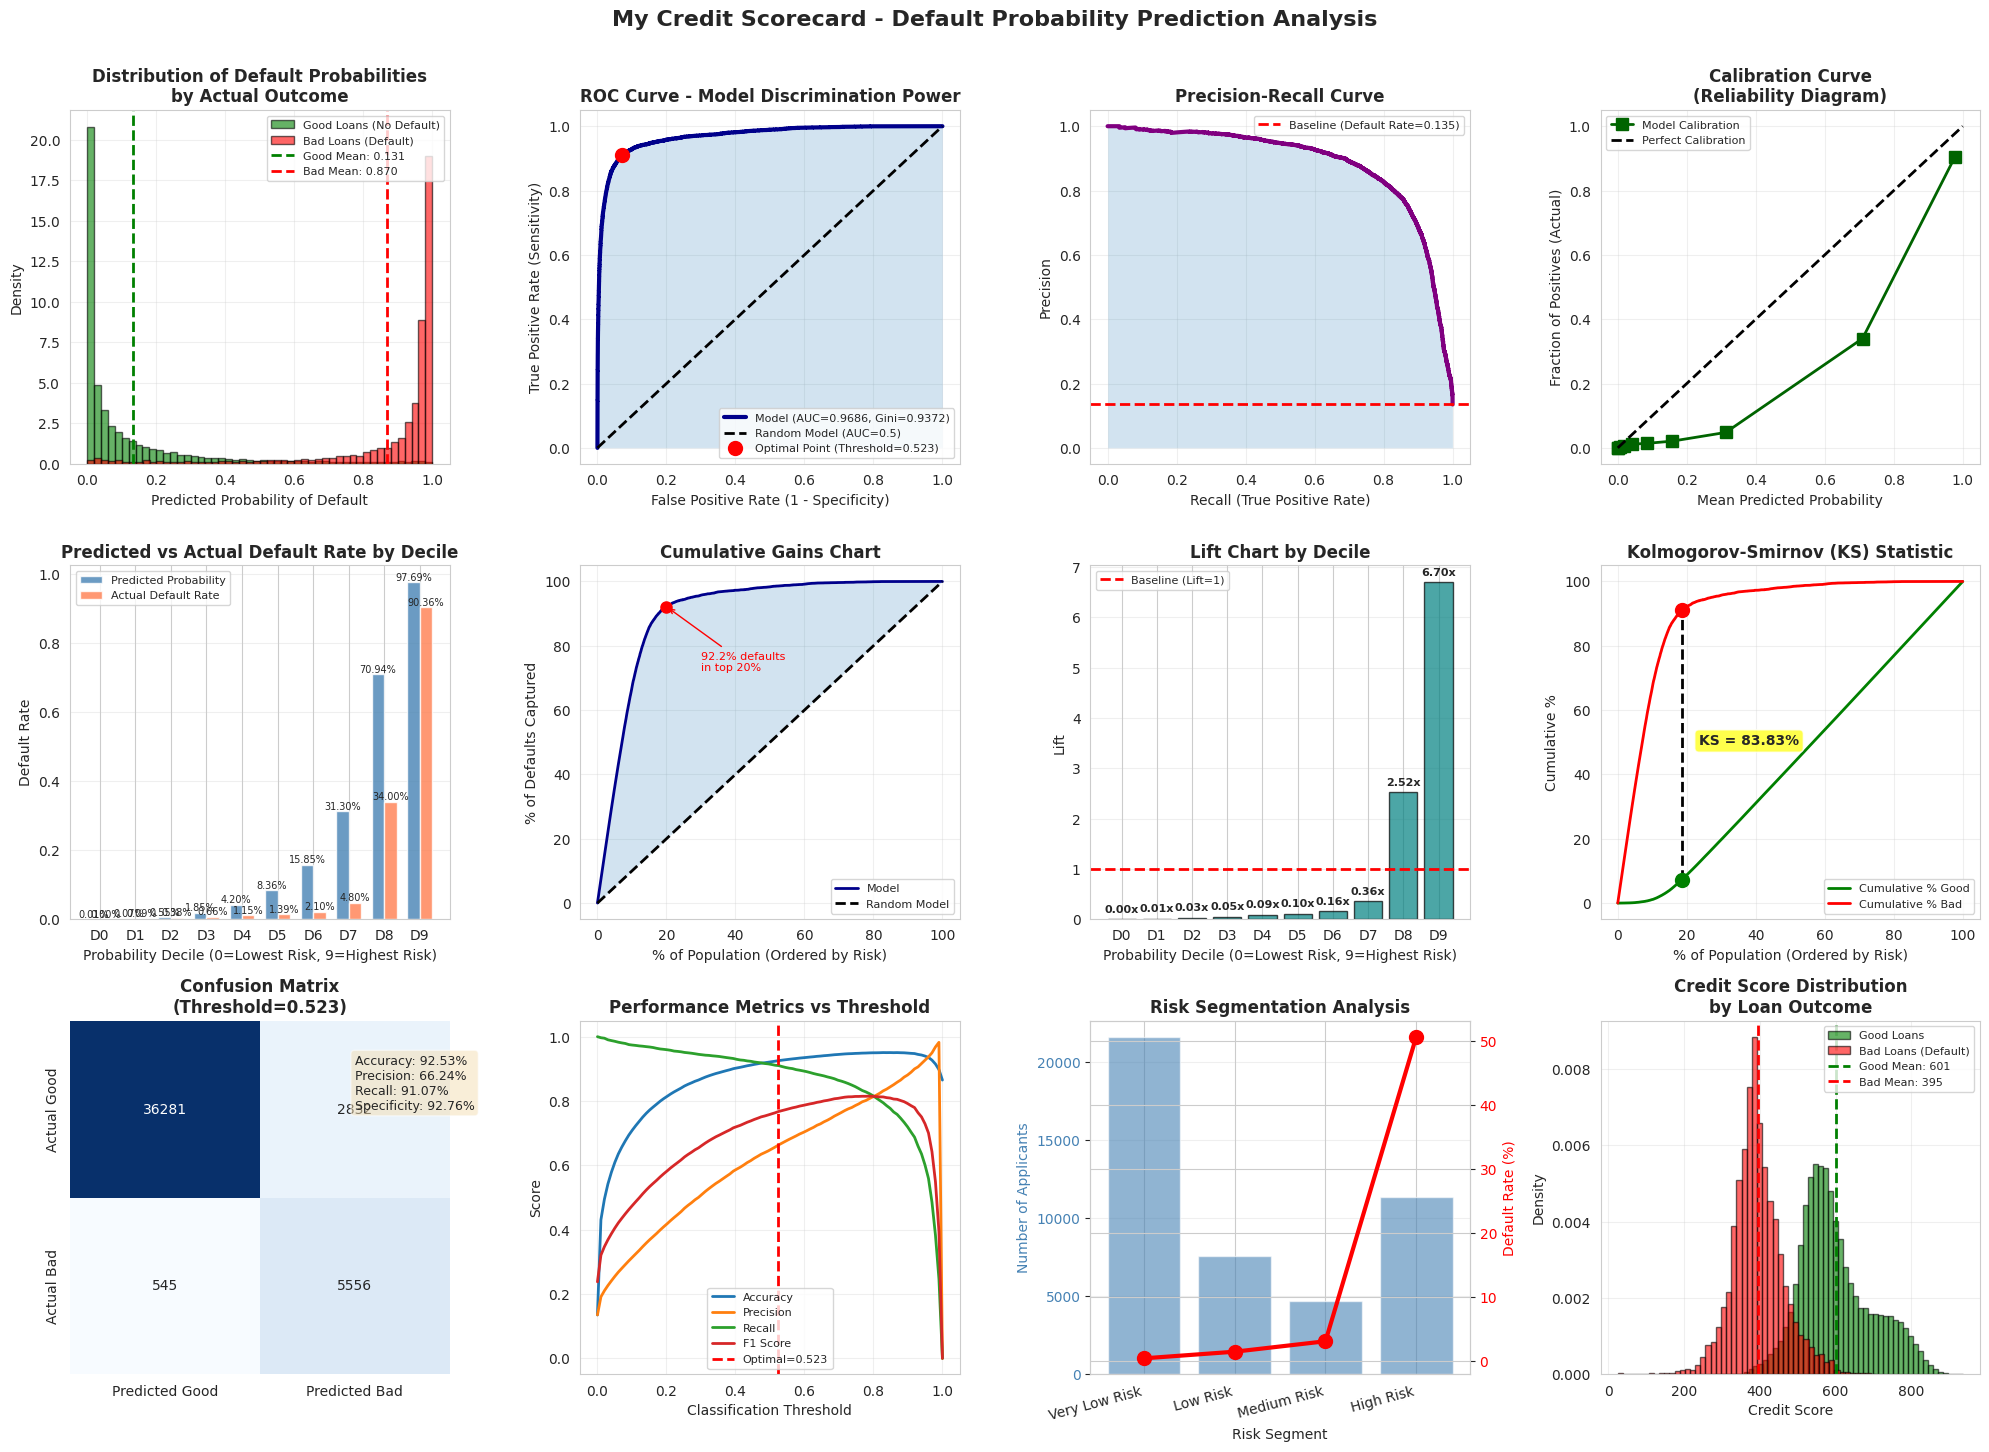


DEFAULT PROBABILITY PREDICTION - SUMMARY REPORT

📊 DATASET STATISTICS:
   Total Samples: 45,214
   Actual Defaults: 6,101 (13.49%)
   Non-Defaults: 39,113 (86.51%)

📈 MODEL PERFORMANCE:
   AUC-ROC Score: 0.9686
   Gini Coefficient: 0.9372
   KS Statistic: 83.83%

🎯 PROBABILITY STATISTICS:
   Mean Probability (Good Loans): 0.1312
   Mean Probability (Bad Loans): 0.8697
   Median Probability (Good Loans): 0.0369
   Median Probability (Bad Loans): 0.9679

⚖️ OPTIMAL THRESHOLD ANALYSIS:
   Optimal Threshold: 0.5229
   Accuracy at Optimal: 92.53%
   Precision at Optimal: 66.24%
   Recall at Optimal: 91.07%
   Specificity at Optimal: 92.76%

📊 DECILE ANALYSIS:

 decile  actual_default_rate  count  predicted_prob
      0             0.000000   4522        0.000053
      1             0.000885   4521        0.000737
      2             0.003760   4521        0.005494
      3             0.006634   4522        0.018477
      4             0.011502   4521        0.041980
      5             0.0

In [36]:
# 3. Generate ALL visualizations at once
results = plot_default_probability_analysis(
    y_true=y_test.values,
    y_pred_proba=y_test_proba,
    scores=test_scores,
    model_name="My Credit Scorecard"
)